# Annotating plots - Gaia - CMD

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Rectangle, Circle, Ellipse, Polygon

from astropy.table import QTable
from astropy import units as u
from astroquery.gaia import Gaia

### NGC 2682 (M 67) is a very well studied open star cluster in the northern skies

&nbsp;

<p>
<img src="https://uwashington-astro300.github.io/A300_images/M67.jpg" width = "500">
</p>


- Right ascension: 08h 51.3m (132.825 deg)
- Declination: +11° 49′ (11.817 deg)

In [3]:
my_object_ra = 132.825
my_object_dec = 11.817

---

## Getting Good Gaia Data

We have only used a small subset of the data availible in the `gaia_source_lite` database. Let's grab a another column to increase the quality of our data:

[gaia_source_lite data columns](https://gaia.aip.de/metadata/gaiadr3/gaia_source_lite/)

```
parallax_over_error         Parallax divided by its standard error
```

The `parallax_over_error` column will allow use to get high quality parallax data. 

- It is very common to judge the quality of data by comparing the data (signal) to the error in the data (noise). 
- The ratio of the data / error is often called the signal-to-noise ratio (SNR). 
- The SNR for data is often referred to by a lower case sigma (σ)

The `parallax_over_error` column is the SNR for the parallax data.

What is considered a good SNR really depends on the particular situation. 

- As a very general rule of thumb is that a SNR of 10 (10σ) is high quality data. 
- A SNR of 3 (3σ) is considered "barely detected".

## Gaia query for 10σ data for our target

- Note the use of `f-string` and variables in the query
- Gaia wants the object coordinates in degrees

In [4]:
my_query = f"""
SELECT TOP 1000
source_id, ra, dec, phot_g_mean_mag, bp_rp, parallax, parallax_over_error
FROM gaiadr3.gaia_source_lite
WHERE DISTANCE( POINT({my_object_ra}, {my_object_dec}), POINT(ra, dec) ) < 0.3
AND parallax_over_error > 10
AND bp_rp IS NOT NULL
ORDER BY parallax DESC
"""

In [5]:
print(my_query)


SELECT TOP 1000
source_id, ra, dec, phot_g_mean_mag, bp_rp, parallax, parallax_over_error
FROM gaiadr3.gaia_source_lite
WHERE DISTANCE( POINT(132.825, 11.817), POINT(ra, dec) ) < 0.3
AND parallax_over_error > 10
AND bp_rp IS NOT NULL
ORDER BY parallax DESC



In [6]:
my_job_query = Gaia.launch_job(my_query)

In [7]:
print(my_job_query)

<Table length=985>
        name         dtype  unit                            description                            
------------------- ------- ---- ------------------------------------------------------------------
          source_id   int64      Unique source identifier (unique within a particular Data Release)
                 ra float64  deg                                                    Right ascension
                dec float64  deg                                                        Declination
    phot_g_mean_mag float32  mag                                              G-band mean magnitude
              bp_rp float32  mag                                                     BP - RP colour
           parallax float64  mas                                                           Parallax
parallax_over_error float32                                  Parallax divided by its standard error
Jobid: None
Phase: COMPLETED
Owner: None
Output file: 1706745773144O-result.vot.g

In [8]:
my_table = my_job_query.get_results()

In [9]:
my_table[0:2]

source_id,ra,dec,phot_g_mean_mag,bp_rp,parallax,parallax_over_error
,deg,deg,mag,mag,mas,
int64,float64,float64,float32,float32,float64,float32
604974322923169152,132.66487216005032,12.04251345658294,13.603463,2.3398438,17.40886546057584,1000.03986
604900586924769024,133.0708801366628,11.685665245167069,15.538209,2.8273697,13.499876725903928,311.27304


### Use `parallax` and `phot_g_mean_mag` to get **distance** and **absolute magnitude**

- Add then as columns to the data table

In [10]:
my_table['distance'] = my_table['parallax'].to(u.parsec, equivalencies=u.parallax())

In [11]:
my_table[0:2]

source_id,ra,dec,phot_g_mean_mag,bp_rp,parallax,parallax_over_error,distance
,deg,deg,mag,mag,mas,,pc
int64,float64,float64,float32,float32,float64,float32,float64
604974322923169152,132.66487216005032,12.04251345658294,13.603463,2.3398438,17.40886546057584,1000.03986,57.4419971401699
604900586924769024,133.0708801366628,11.685665245167069,15.538209,2.8273697,13.499876725903928,311.27304,74.07475048132646


In [12]:
def find_absmag(my_gmag, my_distance):
    result = my_gmag - 5 * np.log10( my_distance / (10 * u.parsec)) * u.mag
    return result

In [13]:
my_table['abs_g'] = find_absmag(my_table['phot_g_mean_mag'], my_table['distance']) * u.mag

In [14]:
my_table[0:2]

source_id,ra,dec,phot_g_mean_mag,bp_rp,parallax,parallax_over_error,distance,abs_g
,deg,deg,mag,mag,mas,,pc,mag
int64,float64,float64,float32,float32,float64,float32,float64,float64
604974322923169152,132.66487216005032,12.04251345658294,13.603463,2.3398438,17.40886546057584,1000.03986,57.4419971401699,9.80731551779663
604900586924769024,133.0708801366628,11.685665245167069,15.538209,2.8273697,13.499876725903928,311.27304,74.07475048132646,11.189857975256617


## Plot a histogram of the distances

- All the stars in the cluster should have the same distance
- Objects not in the cluster will have different distances

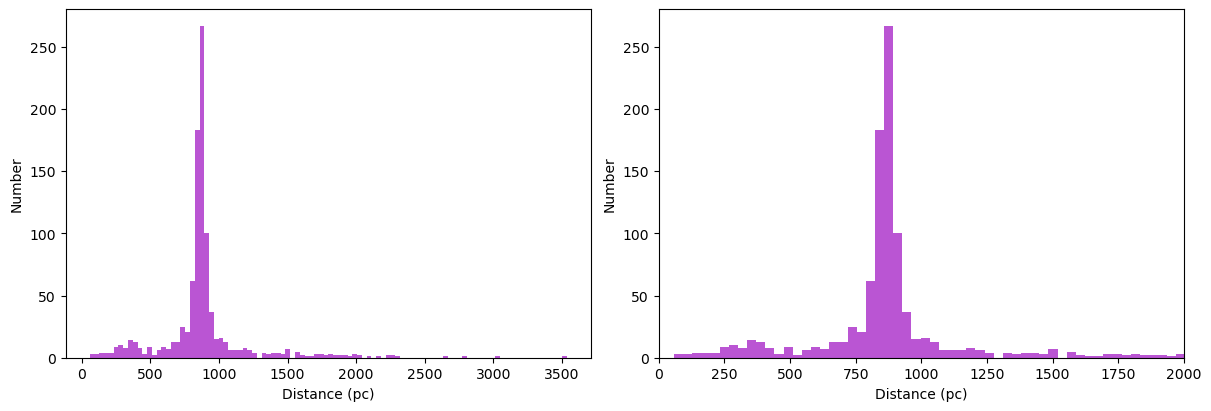

In [15]:
fig, ax = plt.subplot_mosaic(
    '''
    AB
    ''',
    figsize = (12, 4), 
    constrained_layout = True
)

ax['A'].set_xlabel("Distance (pc)")
ax['A'].set_ylabel("Number")

ax['A'].hist(my_table['distance'],
        bins = 100,
        histtype = 'stepfilled',
        facecolor = 'MediumOrchid')

ax['B'].set_xlim(0, 2000)

ax['B'].set_xlabel("Distance (pc)")
ax['B'].set_ylabel("Number")

ax['B'].hist(my_table['distance'],
        bins = 100,
        histtype = 'stepfilled',
        facecolor = 'MediumOrchid');

## Pretty easy to see the cluster's distance

- We will use distances between 750 pc and 1000 pc for cluster stars
- The cluster distance from the literature is 800 - 900 pc, so these values seems fine.

In [16]:
my_cluster_table = my_table[(my_table['distance'] > 750) &
                            (my_table['distance'] < 1000)
                           ]

In [17]:
len(my_cluster_table) / len(my_table)

0.7015228426395939

## Make a color magnitude diagram (CMD) of the object


Color Magnitude Diagram (CMD) is a plot of Color Index vs. Magnitude. This is just a HR-diagram with a change of units.

Some things we have to keep in mind when making a CMD

- Color Index (X-axis) cover a very small range of values, we will need to adjust our axes accordingly.
- Magnitudes (Y-axis) are backwards, we will need to adjust our axes accordingly.

#### `np.ptp()` returns the range of values (max - min) for an array (*P*eak *T*o *P*eak)

In [18]:
np.ptp(my_cluster_table['bp_rp'])

2.0662556

In [19]:
np.ptp(my_cluster_table['abs_g'])

9.819335574003283

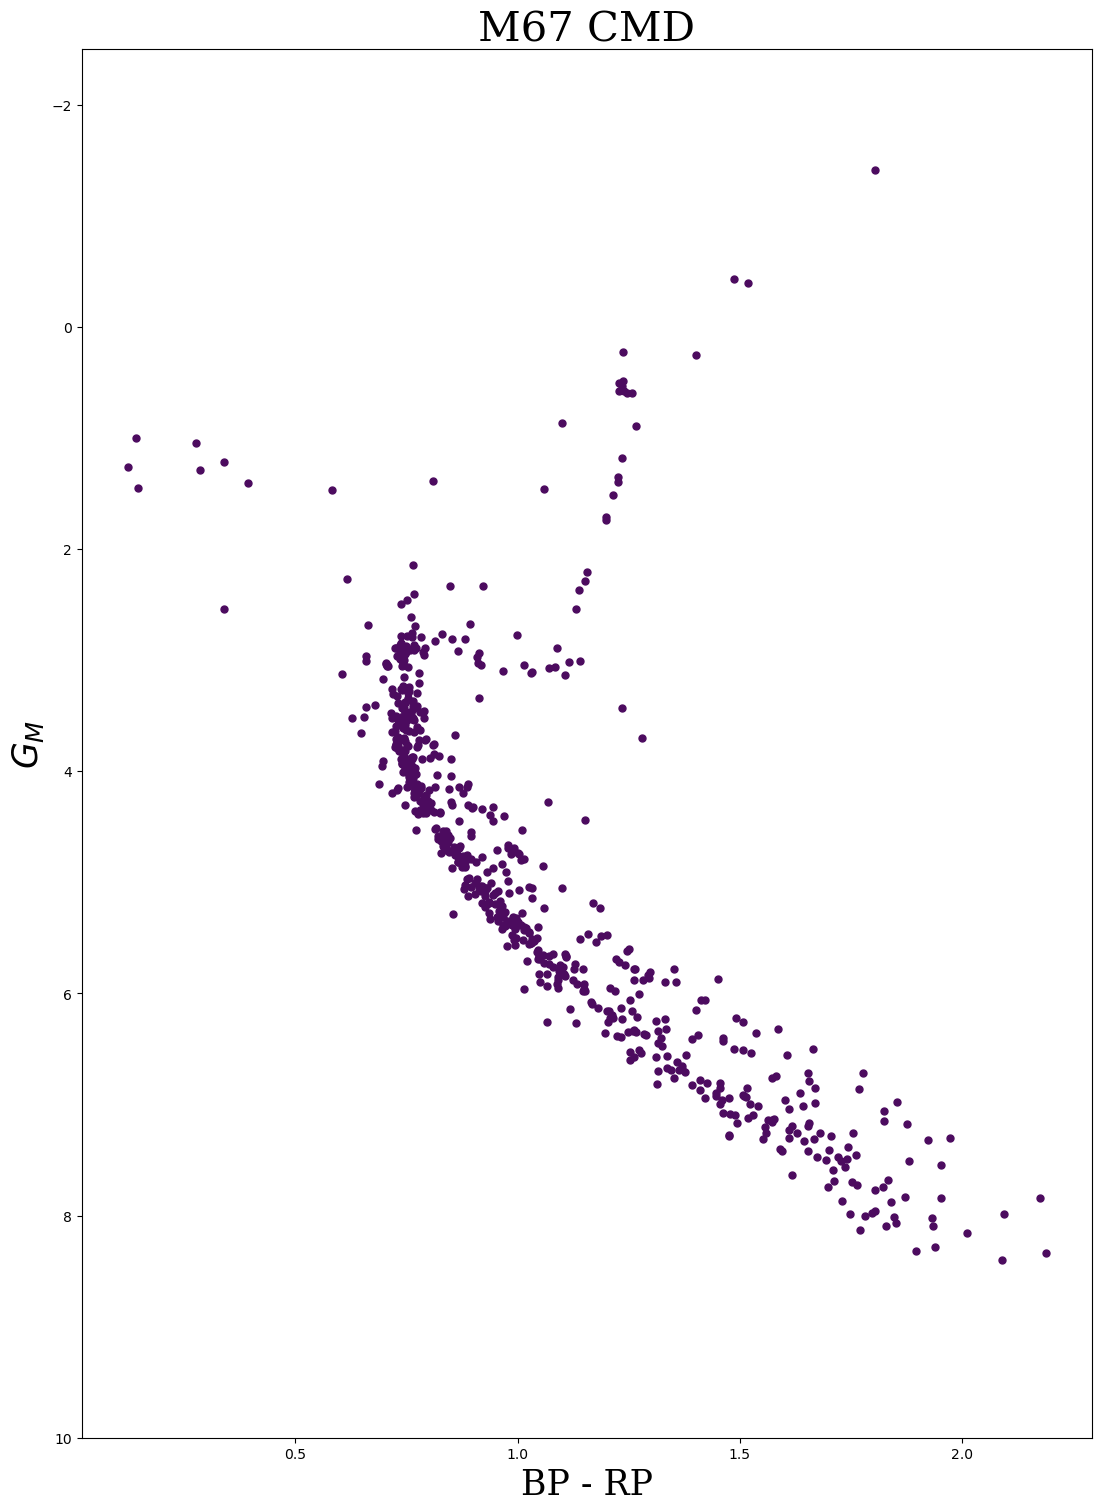

In [20]:
fig, ax = plt.subplots(
    figsize = (15, 15), 
    constrained_layout = True
)

# Color Index cover a very small range of values
# Make 1 unit in X = 4 units in Y

ax.set_aspect(1 / 4)

# Magnitudes are backwards

ax.set_ylim(-2.5,10)
ax.invert_yaxis()

###

ax.set_xlabel("BP - RP",
              fontfamily = 'serif',
              fontsize = 25)

ax.set_ylabel(r"$G_{M}$",
              fontfamily = 'serif',
              fontsize = 25)

ax.set_title(f"M67 CMD",
             fontfamily = 'serif',
             fontsize = 30)

### Plot Data ###

ax.plot(my_cluster_table['bp_rp'], my_cluster_table['abs_g'],
        color = "#4C0B5F",
        marker = "o",
        linestyle = "None",
        markersize = 5
       );